In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from random import choices
from trial_1 import Building
from trial_1 import Area

# define class for building
# class Building:
#     def __init__(self, id, geometry, center_point, bld_type):
#         self.id = id
#         self.geometry = geometry
#         self.center_point = center_point
#         self.bld_type = bld_type

# importing osm location
address = "Çimentepe Mahallesi"
buildings = ox.features.features_from_address(address, tags={'building': True}, dist=350)

# creating area
area = Area(1, address)

# creating object for each building
bld_lst = []
for i in buildings.index:
    id = i[1]
    geo = buildings.loc[i, 'geometry']
    center_point = geo.centroid
    bld_function = buildings.loc[i, 'building']

    bld = Building(id, geo, center_point, bld_function)
    bld_lst.append(bld)

[0, 24.333333333333332, [<trial_1.Building object at 0x000001BA1F800190>, <trial_1.Building object at 0x000001BA1F8000D0>, <trial_1.Building object at 0x000001BA1F7FEE20>]]
[1, 57.0, [<trial_1.Building object at 0x000001BA1F800EE0>]]
[2, 48.5, [<trial_1.Building object at 0x000001BA1F800F10>, <trial_1.Building object at 0x000001BA2013CF70>]]
[3, 55.5, [<trial_1.Building object at 0x000001BA2077A910>, <trial_1.Building object at 0x000001BA2077A940>, <trial_1.Building object at 0x000001BA2077A970>, <trial_1.Building object at 0x000001BA2077A9A0>, <trial_1.Building object at 0x000001BA20151E20>, <trial_1.Building object at 0x000001BA2077A9D0>]]
[4, 39.54545454545455, [<trial_1.Building object at 0x000001BA20151D90>, <trial_1.Building object at 0x000001BA1F800820>, <trial_1.Building object at 0x000001BA2013CB50>, <trial_1.Building object at 0x000001BA20151E80>, <trial_1.Building object at 0x000001BA1F800F70>, <trial_1.Building object at 0x000001BA20151EB0>, <trial_1.Building object at 0x00

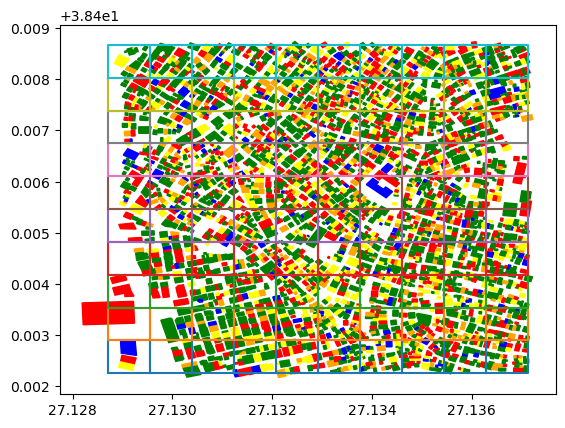

In [2]:
import numpy as np
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_polygon
from trial_1 import Sub_Area
from trial_1 import Area

center_points = gpd.GeoDataFrame({'points': [o.center_point for o in bld_lst]}, geometry = 'points')

# set bounds of graph to the bounds of center points
xmin, ymin, xmax, ymax = center_points.total_bounds
x_range = xmax - xmin
y_range = ymax - ymin

# set stepsize
width = x_range / 10
height = y_range / 10

# create cols and rows based on bounds and stepsize
cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax + height, height))

# create empty graph
fig, ax = plt.subplots()

# sort the list of buildings objects based on x coordinates, then y coordinates
sorted_blds = sorted(bld_lst, key=lambda x: (x.center_point.x, x.center_point.y))

# create cells and plot to graph, add buildings to subarea classes
sub_areas = []
i = 0
j = 0
for x in cols[:-1]:
    # while the buildings have x values in the range of this column, add them to a list
    filt_blds = []
    while (sorted_blds[i].center_point.x >= x) and (sorted_blds[i].center_point.x < (x+width)): 
        filt_blds.append(sorted_blds[i])
        filt_blds = sorted(filt_blds, key=lambda x: (x.center_point.y))
        i += 1
    for y in rows[:-1]:
        # create a cell, sub_area object, and associate the cell with the object
        polygon = Polygon([(x,y), (x+width, y), (x+width, y+height), (x, y+height)])
        sub_area = Sub_Area(j)
        j += 1
        ax.plot(*polygon.exterior.xy)
        sub_area_blds = []
        # while the buildings in that column have y values in the range of this row, add them to the cell object 
        while (len(filt_blds) > 0) and (filt_blds[0].center_point.y >= y) and (filt_blds[0].center_point.y < (y+height)):
            sub_area.add_building(filt_blds.pop(0))
        sub_areas.append(sub_area)
        # add the sub_areas to the area
        area.add_sub_area(sub_area)

for o in area.sub_areas:
    print([o.sub_area_id, o.priority_weight, o.buildings])

# this is plotting the geometry of the buildings
# save each geometry attribute in a list
geos = [o.geometry for o in bld_lst]

# choices of different colours with corresponding weights
population = ['green', 'blue', 'yellow', 'orange', 'red']
weights = [0.45, 0.05, 0.15, 0.12, 0.23]

# for every geometry choose a colour, fill the geometry and plot to graph
for g in geos:
    c = choices(population, weights)[0]
    x, y = g.exterior.xy
    ax.fill(x, y, color = c)

# Display the plot
plt.show()

In [3]:
from trial_1 import Team
from trial_1 import Sub_Team
from trial_1 import Team_Member
import random

# initialise amount of teams to be distributed in sector
n_heavy = 2
n_med = 1
n_light = 1

# create all objects in sector and link them
teams = []
team_id = 0
sub_team_id = 0
team_member_id = 0

# create heavy teams, subteams and teammembers
for i in range(n_heavy):
    team = Team(team_id, 'heavy')
    for j in range(10):
        sub_team = Sub_Team(sub_team_id)
        for k in range(6):
            team_member = Team_Member(team_member_id, random.randint(5, 10))
            sub_team.add_team_member(team_member)
            team_member_id += 1
        team.add_sub_team(sub_team)
        sub_team_id += 1
    teams.append(team)
    team_id += 1

# create medium teams, subteams and teammembers
for i in range(n_med):
    team = Team(team_id, 'medium')
    for j in range(6):
        sub_team = Sub_Team(sub_team_id)
        for k in range(6):
            team_member = Team_Member(team_member_id, random.randint(3, 9))
            sub_team.add_team_member(team_member)
            team_member_id += 1
        team.add_sub_team(sub_team)
        sub_team_id += 1
    teams.append(team)
    team_id += 1
    
# create light teams, subteams and teammembers
for i in range(n_light):
    team = Team(team_id, 'light')
    for j in range(3):
        sub_team = Sub_Team(sub_team_id)
        for k in range(6):
            team_member = Team_Member(team_member_id, random.randint(1, 8))
            sub_team.add_team_member(team_member)
            team_member_id += 1
        team.add_sub_team(sub_team)
        sub_team_id += 1
    teams.append(team)
    team_id += 1

# access and print all team_member_id's, and create sub_teams list
sub_teams = []
for tm in teams:
    tms = []
    for stm in tm.sub_teams:
        sub_teams.append(stm)
        tmms = [tmm.team_member_id for tmm in stm.team_members]
        tms.append(tmms)
    print(tms)   

[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17], [18, 19, 20, 21, 22, 23], [24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35], [36, 37, 38, 39, 40, 41], [42, 43, 44, 45, 46, 47], [48, 49, 50, 51, 52, 53], [54, 55, 56, 57, 58, 59]]
[[60, 61, 62, 63, 64, 65], [66, 67, 68, 69, 70, 71], [72, 73, 74, 75, 76, 77], [78, 79, 80, 81, 82, 83], [84, 85, 86, 87, 88, 89], [90, 91, 92, 93, 94, 95], [96, 97, 98, 99, 100, 101], [102, 103, 104, 105, 106, 107], [108, 109, 110, 111, 112, 113], [114, 115, 116, 117, 118, 119]]
[[120, 121, 122, 123, 124, 125], [126, 127, 128, 129, 130, 131], [132, 133, 134, 135, 136, 137], [138, 139, 140, 141, 142, 143], [144, 145, 146, 147, 148, 149], [150, 151, 152, 153, 154, 155]]
[[156, 157, 158, 159, 160, 161], [162, 163, 164, 165, 166, 167], [168, 169, 170, 171, 172, 173]]


In [4]:
sub_areas = sorted(sub_areas, key=lambda x: (x.priority_weight), reverse=True)
print([o.priority_weight for o in sub_areas])

sub_teams = sorted(sub_teams, key=lambda x: (x.competence), reverse=True)
print([o.competence for o in sub_teams])



[63.766666666666666, 60.666666666666664, 59.734375, 58.86666666666667, 58.266666666666666, 58.0, 57.904761904761905, 57.6875, 57.541666666666664, 57.48979591836735, 57.44444444444444, 57.351351351351354, 57.0, 56.78125, 56.4054054054054, 56.23943661971831, 56.03846153846154, 56.03333333333333, 55.5, 55.470588235294116, 54.91428571428571, 54.44827586206897, 54.17142857142857, 53.95348837209303, 53.888888888888886, 53.8235294117647, 53.333333333333336, 53.21212121212121, 53.095238095238095, 53.054054054054056, 52.7, 52.679245283018865, 52.490566037735846, 52.333333333333336, 52.06, 51.53333333333333, 51.47826086956522, 51.254901960784316, 51.02439024390244, 50.6578947368421, 50.54237288135593, 50.5, 50.38461538461539, 50.35087719298246, 50.291666666666664, 50.142857142857146, 49.967213114754095, 49.88, 49.857142857142854, 49.6, 49.20454545454545, 49.166666666666664, 49.166666666666664, 48.98148148148148, 48.611111111111114, 48.5, 48.2093023255814, 48.142857142857146, 48.08888888888889, 4

In [28]:
"""Hops flask middleware example"""
import sys
import os
from flask import Flask
from PIL import Image
import rhino3dm as rs

# load ghhops-server-py source from this directory
import ghhops_server as hs

# register hops app as middleware
app = Flask(__name__)
hops: hs.HopsFlask = hs.Hops(app)

# flask app can be used for other stuff directly
@app.route("/help")
def help():
    return "Welcome to Grashopper Hops for CPython!"


@app.route("/update", methods=["POST"])
def update():
    return "Update example!"

# component
@hops.component(
    "/imft",
    name="ImportFootprints",
    nickname="IF",
    description="Import Building Footprints",
    outputs=[hs.HopsPoint("Footprints", "F", "List of footprints imported")]
)

def import_footprints():
    c_pts = []
    for geo in geos:
        points = []
        for point in geo.exterior.coords:
            x, y = point
            rh_point = rs.Point3d(x, y, 0)
            points.append(rh_point)
        c_pts.append(points)
    polygon = rs.Curve.CreateControlPointCurve(c_pts)
    return hs.HopsCurve(polygon)

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)


 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


[INFO]  * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "GET /imft HTTP/1.1" 200 -
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "GET /imft HTTP/1.1" 200 -
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1ddd0a31040>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1ddd0a317c0>
[INFO] Solving using legacy API: <HopsComponent /imft [ -> ImportFootprints -> Footprints] >
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "POST /solve HTTP/1.1" 200 -
